In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../")

In [75]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torchsummary import summary

from data.input_transforms import InputTransform
from data.cifar import CIFAR
from data.stl import STL, LABEL_MAP
from data.dataloader import get_dataloader
from models.optimizer import optimizer, scheduler
from networks.twolayernet import TwolayerNet
from networks.convnet import ConvNet
from utils.viz import plot_multiple_quantities_by_time, show_many_images
from main import train, evaluate, fix_seed

### Load dataset

In [4]:
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
valid_transform = InputTransform(valid_transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)


### Load model

In [5]:
# test checkpoint loading
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_best_hparams.pt",
    return_features=True,
)

#### Visualize samples from the dataset

In [6]:
valid_labels = valid_dataset.targets
classes = np.unique(valid_labels)

indices = []
sampled = []
for i, l in enumerate(valid_labels):
    if l not in sampled:
        indices.extend(np.random.choice(np.where(valid_labels == l)[0], 2))
        sampled.append(l)

In [7]:
indices, sampled

([335, 408, 451, 52, 197, 479, 20, 180, 89, 86], [2, 4, 1, 6, 9])

In [8]:
images = []
labels = []

for i in indices:
    image = valid_dataset.data[i]
    label = valid_dataset.targets[i]
    images.append(image)
    labels.append(label)

In [9]:
valid_labels[indices]

array([2, 2, 4, 4, 1, 1, 6, 6, 9, 9])

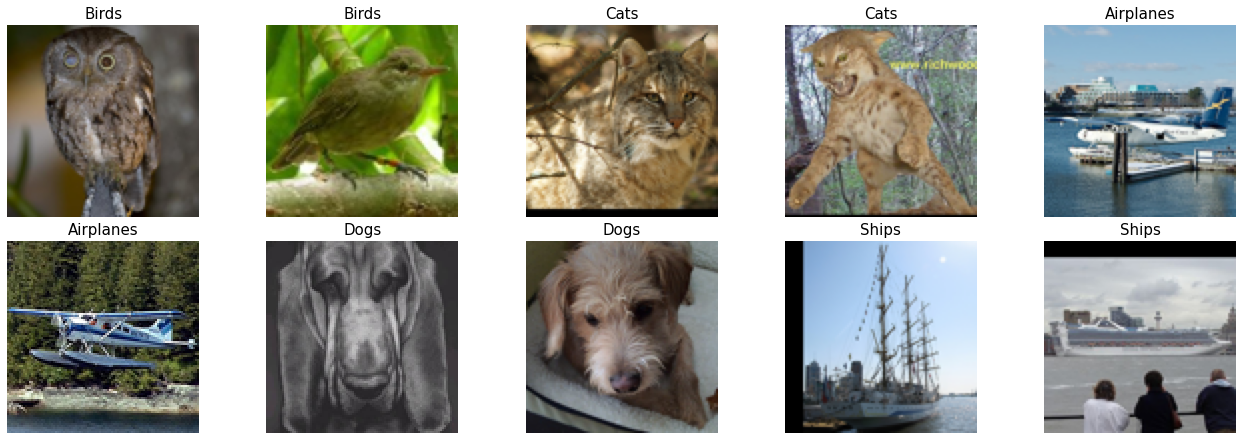

In [10]:
show_many_images(
    images, grid=(2, 5),
    subtitles=[LABEL_MAP[x].capitalize() for x in labels],
    save=True, save_path="../results/stl_samples.png",
)

### Visualize features without finetuning

In [11]:
net = net.eval()

In [12]:
val_features = []
valid_labels = []

iterator = tqdm(valid_loader, f"Extracting features", bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')
with torch.no_grad():
    for i, batch in enumerate(iterator):
        images, targets = batch
        output = net(images)
        val_features.append(output.numpy())
        valid_labels.append(targets.numpy())

Extracting features: 100%|██████████████████████████████| 4/4 [00:00<00:00, 63.75it/s]                          


In [13]:
valid_features = np.vstack(val_features)
valid_labels = np.concatenate(valid_labels)

In [14]:
valid_features.shape, valid_labels.shape

((500, 84), (500,))

In [15]:
X = valid_features
y = valid_labels

In [16]:
def visualize_features(
        X, y,
        title="Sample features",
        seed=0,
        save=False,
        save_path="../results/sample.png",
        show=True,
    ):
    np.random.seed(seed)

    tsne = TSNE(n_components=2, random_state=seed)
    Z = tsne.fit_transform(X)

    df = pd.DataFrame(None, columns=["Z1", "Z2", "label"])
    df["Z1"] = Z[:, 0]
    df["Z2"] = Z[:, 1]
    df["label"] = [LABEL_MAP[a].capitalize() for a in y]

    fig, ax = plt.subplots(1, 1, figsize=(11, 7))
    ax.grid()
    sns.scatterplot(
        data=df,
        x="Z1", y="Z2", hue="label", palette="Set2", legend=True, ax=ax, s=100,
    )
    ax.set_title(title, fontsize=17)
    
    plt.legend(fontsize=14)

    if save:
        plt.savefig(save_path, bbox_inches="tight")
    
    if save:
        plt.show()

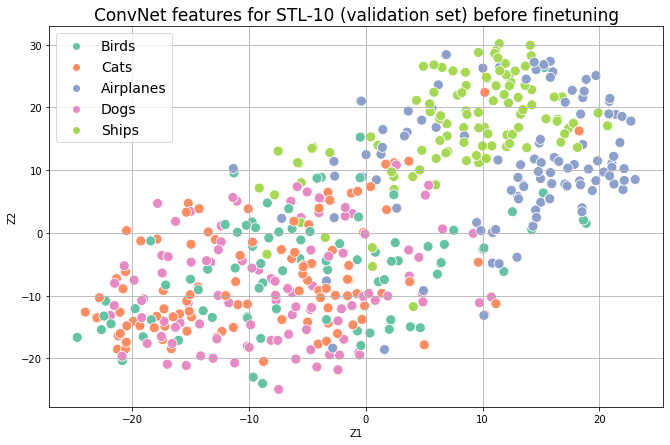

In [17]:
visualize_features(
    X, y,
    title="ConvNet features for STL-10 (validation set) before finetuning",
    save_path="../results/convnet_features_before_finetuning.png", save=True,
)

### Evaluate pre-trained model on new validation set without finetuning

In [18]:
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
valid_transform = InputTransform(valid_transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform, encode_labels=True)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)


In [19]:
# test checkpoint loading
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_best_hparams.pt",
    return_features=False,
)
net = net.eval()

In [20]:
evaluate(net, valid_loader, nn.CrossEntropyLoss(), 1, 1, mode="valid")

Evaluate: Epoch [1/1]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 67.21it/s]                        

VALID 	: Summary: Loss: 1.8428 Accuracy: 0.1800


(1.8428387939929962, 0.18)

### Train the network

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)
:::: Loaded dataset from ../datasets/STL-10/: X ((2000, 96, 96, 3)) y (2000)
:::: Loaded dataset from ../datasets/STL-10/: X ((4000, 96, 96, 3)) y (4000)


Evaluate: Epoch [1/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 34.56it/s]                       


VALID 	: Summary: Loss: 1.6697 Accuracy: 0.2460
TRAIN 	: Summary: Loss: 1.7649 Accuracy: 0.2375


Evaluate: Epoch [2/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.86it/s]                       


VALID 	: Summary: Loss: 1.5352 Accuracy: 0.3280
TRAIN 	: Summary: Loss: 1.5773 Accuracy: 0.2970


Evaluate: Epoch [3/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.61it/s]                       


VALID 	: Summary: Loss: 1.4094 Accuracy: 0.4060
TRAIN 	: Summary: Loss: 1.4389 Accuracy: 0.3955


Evaluate: Epoch [4/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.02it/s]                       


VALID 	: Summary: Loss: 1.3223 Accuracy: 0.4380
TRAIN 	: Summary: Loss: 1.3265 Accuracy: 0.4415


Evaluate: Epoch [5/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.63it/s]                       


VALID 	: Summary: Loss: 1.2525 Accuracy: 0.4800
TRAIN 	: Summary: Loss: 1.2375 Accuracy: 0.4835


Evaluate: Epoch [6/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.86it/s]                       


VALID 	: Summary: Loss: 1.2196 Accuracy: 0.4900
TRAIN 	: Summary: Loss: 1.1736 Accuracy: 0.5075


Evaluate: Epoch [7/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.25it/s]                       


VALID 	: Summary: Loss: 1.1832 Accuracy: 0.4880
TRAIN 	: Summary: Loss: 1.1184 Accuracy: 0.5310


Evaluate: Epoch [8/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.51it/s]                       


VALID 	: Summary: Loss: 1.1247 Accuracy: 0.5300
TRAIN 	: Summary: Loss: 1.0798 Accuracy: 0.5445


Evaluate: Epoch [9/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.25it/s]                       


VALID 	: Summary: Loss: 1.1341 Accuracy: 0.5360
TRAIN 	: Summary: Loss: 1.0499 Accuracy: 0.5555


Evaluate: Epoch [10/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 37.95it/s]                      


VALID 	: Summary: Loss: 1.1010 Accuracy: 0.5400
TRAIN 	: Summary: Loss: 1.0237 Accuracy: 0.5690


Evaluate: Epoch [11/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.85it/s]                      


VALID 	: Summary: Loss: 1.0728 Accuracy: 0.5420
TRAIN 	: Summary: Loss: 1.0015 Accuracy: 0.5715


Evaluate: Epoch [12/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.99it/s]                      


VALID 	: Summary: Loss: 1.0788 Accuracy: 0.5260
TRAIN 	: Summary: Loss: 0.9821 Accuracy: 0.5830


Evaluate: Epoch [13/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 29.77it/s]                      


VALID 	: Summary: Loss: 1.0654 Accuracy: 0.5680
TRAIN 	: Summary: Loss: 0.9652 Accuracy: 0.5940


Evaluate: Epoch [14/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.41it/s]                      


VALID 	: Summary: Loss: 1.0347 Accuracy: 0.5780
TRAIN 	: Summary: Loss: 0.9459 Accuracy: 0.6025


Evaluate: Epoch [15/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.01it/s]                      


VALID 	: Summary: Loss: 1.0311 Accuracy: 0.5820
TRAIN 	: Summary: Loss: 0.9323 Accuracy: 0.6100


Evaluate: Epoch [16/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.98it/s]                      


VALID 	: Summary: Loss: 1.0345 Accuracy: 0.5700
TRAIN 	: Summary: Loss: 0.9200 Accuracy: 0.6205


Evaluate: Epoch [17/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.61it/s]                      


VALID 	: Summary: Loss: 1.0015 Accuracy: 0.5860
TRAIN 	: Summary: Loss: 0.9059 Accuracy: 0.6270


Evaluate: Epoch [18/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.11it/s]                      


VALID 	: Summary: Loss: 1.0093 Accuracy: 0.5640
TRAIN 	: Summary: Loss: 0.8929 Accuracy: 0.6310


Evaluate: Epoch [19/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.67it/s]                      


VALID 	: Summary: Loss: 0.9739 Accuracy: 0.5780
TRAIN 	: Summary: Loss: 0.8794 Accuracy: 0.6365


Evaluate: Epoch [20/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.45it/s]                      


VALID 	: Summary: Loss: 1.0115 Accuracy: 0.5720
TRAIN 	: Summary: Loss: 0.8673 Accuracy: 0.6460


Evaluate: Epoch [21/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.26it/s]                      


VALID 	: Summary: Loss: 1.0158 Accuracy: 0.5880
TRAIN 	: Summary: Loss: 0.8553 Accuracy: 0.6435


Evaluate: Epoch [22/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.57it/s]                      


VALID 	: Summary: Loss: 0.9976 Accuracy: 0.6020
TRAIN 	: Summary: Loss: 0.8435 Accuracy: 0.6520


Evaluate: Epoch [23/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 40.18it/s]                      


VALID 	: Summary: Loss: 0.9577 Accuracy: 0.6120
TRAIN 	: Summary: Loss: 0.8355 Accuracy: 0.6560


Evaluate: Epoch [24/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.64it/s]                      


VALID 	: Summary: Loss: 0.9628 Accuracy: 0.6020
TRAIN 	: Summary: Loss: 0.8282 Accuracy: 0.6650


Evaluate: Epoch [25/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.50it/s]                      


VALID 	: Summary: Loss: 0.9205 Accuracy: 0.6200
TRAIN 	: Summary: Loss: 0.8154 Accuracy: 0.6660


Evaluate: Epoch [26/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.96it/s]                      


VALID 	: Summary: Loss: 0.8884 Accuracy: 0.6340
TRAIN 	: Summary: Loss: 0.8060 Accuracy: 0.6750


Evaluate: Epoch [27/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 40.02it/s]                      


VALID 	: Summary: Loss: 0.9338 Accuracy: 0.6320
TRAIN 	: Summary: Loss: 0.8015 Accuracy: 0.6820


Evaluate: Epoch [28/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.36it/s]                      


VALID 	: Summary: Loss: 0.9279 Accuracy: 0.6160
TRAIN 	: Summary: Loss: 0.7889 Accuracy: 0.6855


Evaluate: Epoch [29/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.63it/s]                      


VALID 	: Summary: Loss: 0.9115 Accuracy: 0.6240
TRAIN 	: Summary: Loss: 0.7853 Accuracy: 0.6915


Evaluate: Epoch [30/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 37.75it/s]                      


VALID 	: Summary: Loss: 0.9222 Accuracy: 0.6160
TRAIN 	: Summary: Loss: 0.7703 Accuracy: 0.6945


Evaluate: Epoch [31/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.45it/s]                      


VALID 	: Summary: Loss: 0.9178 Accuracy: 0.6220
TRAIN 	: Summary: Loss: 0.7661 Accuracy: 0.6990


Evaluate: Epoch [32/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 30.54it/s]                      


VALID 	: Summary: Loss: 0.9042 Accuracy: 0.6400
TRAIN 	: Summary: Loss: 0.7622 Accuracy: 0.6980


Evaluate: Epoch [33/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.28it/s]                      


VALID 	: Summary: Loss: 0.9109 Accuracy: 0.6360
TRAIN 	: Summary: Loss: 0.7520 Accuracy: 0.7090


Evaluate: Epoch [34/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 37.19it/s]                      


VALID 	: Summary: Loss: 0.8761 Accuracy: 0.6480
TRAIN 	: Summary: Loss: 0.7448 Accuracy: 0.7035


Evaluate: Epoch [35/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 39.28it/s]                      


VALID 	: Summary: Loss: 0.9077 Accuracy: 0.6380
TRAIN 	: Summary: Loss: 0.7368 Accuracy: 0.7090


Evaluate: Epoch [36/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 38.46it/s]                      


VALID 	: Summary: Loss: 0.9094 Accuracy: 0.6200
TRAIN 	: Summary: Loss: 0.7287 Accuracy: 0.7145


Evaluate: Epoch [37/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 36.06it/s]                      


VALID 	: Summary: Loss: 0.8924 Accuracy: 0.6380
TRAIN 	: Summary: Loss: 0.7235 Accuracy: 0.7175


Evaluate: Epoch [38/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 33.59it/s]                      


VALID 	: Summary: Loss: 0.8774 Accuracy: 0.6480
TRAIN 	: Summary: Loss: 0.7168 Accuracy: 0.7235


Evaluate: Epoch [39/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 36.52it/s]                      


VALID 	: Summary: Loss: 0.8896 Accuracy: 0.6360
TRAIN 	: Summary: Loss: 0.7103 Accuracy: 0.7200


Evaluate: Epoch [40/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 30.76it/s]                      


VALID 	: Summary: Loss: 0.8408 Accuracy: 0.6580
TRAIN 	: Summary: Loss: 0.7026 Accuracy: 0.7255


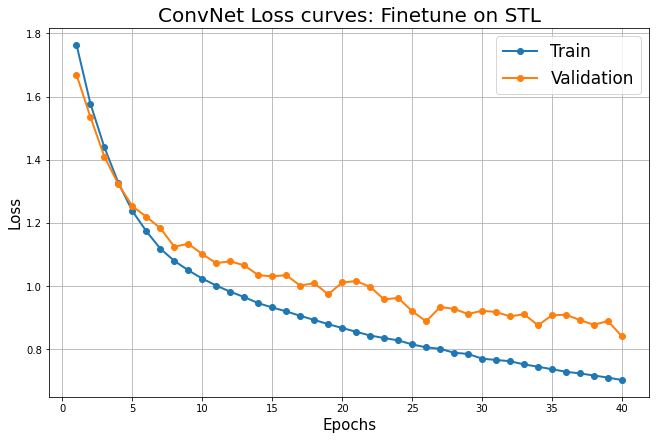

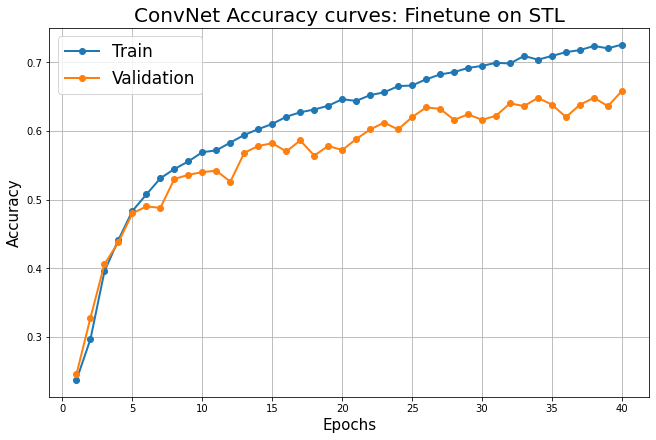

In [82]:
fix_seed(0)

# define network
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_best_hparams.pt",
    return_features=False,
)

# define transforms
train_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
    {
        "name": "RandomAffine",
        "args": {"degrees": 10, "translate": (0.1, 0.1), "scale": (0.8, 1.2)},
    },
]
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
test_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]

# define the datasets
valid_transform = InputTransform(train_transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform, encode_labels=True)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

train_transform = InputTransform(valid_transforms)
train_dataset = STL(root="../datasets/STL-10/", mode="train", transform=train_transform, encode_labels=True)
train_loader = get_dataloader(train_dataset, train=True, batch_size=128, num_workers=0)

test_transform = InputTransform(test_transforms)
test_dataset = STL(root="../datasets/STL-10/", mode="test", transform=test_transform, encode_labels=True)
test_loader = get_dataloader(test_dataset, train=False, batch_size=128, num_workers=0)

# define the optimizer and scheduler

num_epochs = 40
batch_size = 128
opt_args = {"name": "Adam", "lr": 1e-4}

sch_args = None
# sch_args = {"name": "MultiStepLR", "milestones": [20], "gamma": 0.1}

opt = optimizer(model_params=net.parameters(), **opt_args)
sch = None
if sch_args is not None:
    sch = scheduler(opt=opt, **sch_args)
    
# define the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs, train_losses, train_metrics, valid_losses, valid_metrics = train(
    net, loss_fn, train_loader, valid_loader, num_epochs=num_epochs, opt=opt, sch=sch,
)

arch = type(net).__name__

# plot training curves
plot_multiple_quantities_by_time(
    quantities=[train_losses["loss"], valid_losses["loss"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Loss curves: Finetune on STL",
    show=True,
    save=True,
    save_path="../results/cnn_finetuning_loss_plot_default.png",
    ylabel="Loss",
)
plot_multiple_quantities_by_time(
    quantities=[train_metrics["accuracy"], valid_metrics["accuracy"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Accuracy curves: Finetune on STL",
    show=True,
    save=True,
    save_path="../results/cnn_finetuning_accu_plot_default.png",
    ylabel="Accuracy",
)

In [83]:
torch.save(net, "../checkpoints/cnn_finetuned_default_stl.pt")

### Evaluate on test set

In [84]:
evaluate(net, test_loader, nn.CrossEntropyLoss(), 1, 1, mode="test")

Evaluate: Epoch [1/1]: 100%|██████████████████████████████| 32/32 [00:00<00:00, 77.60it/s]                      

TEST 	: Summary: Loss: 0.8075 Accuracy: 0.6675


(0.8074920438230038, 0.6675)

### Visualize features after finetuning

In [85]:
# define the datasets
valid_transform = InputTransform(valid_transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform, encode_labels=False)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)


In [86]:
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_finetuned_default_stl.pt",
    return_features=True,
    layer_to_ignore=None,
)
net = net.eval()

In [87]:
val_features = []
valid_labels = []

iterator = tqdm(valid_loader, f"Extracting features", bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')
with torch.no_grad():
    for i, batch in enumerate(iterator):
        images, targets = batch
        output = net(images)
        val_features.append(output.numpy())
        valid_labels.append(targets.numpy())

Extracting features: 100%|██████████████████████████████| 4/4 [00:00<00:00, 62.32it/s]                          


In [88]:
valid_features = np.vstack(val_features)
valid_labels = np.concatenate(valid_labels)

In [89]:
valid_features.shape, valid_labels.shape

((500, 84), (500,))

In [90]:
X = valid_features
y = valid_labels

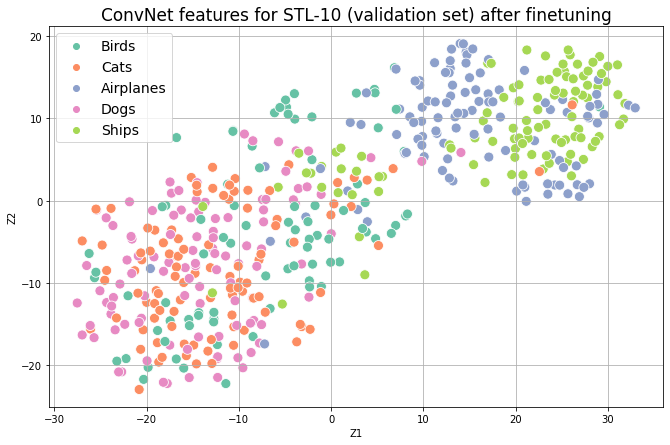

In [91]:
visualize_features(
    X, y,
    title="ConvNet features for STL-10 (validation set) after finetuning",
    save_path="../results/convnet_features_after_finetuning.png", save=True,
)